<a href="https://colab.research.google.com/github/xiekg2020/DL_test/blob/main/helmet_detection_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Make sure you're using TensorFlow 1.15:**

In [1]:
try:
  # This %tensorflow_version magic only works in Colab.
  %tensorflow_version 1.x
except Exception:
  pass
# For your non-Colab code, be sure you have tensorflow==1.15
import tensorflow as tf
assert tf.__version__.startswith('1')

TensorFlow 1.x selected.


# **Build the TF1 Object Detection API:**

In [2]:
! pip install tf_slim
! git clone https://github.com/tensorflow/models.git

     |████████████████████████████████| 358kB 7.5MB/s 
Cloning into 'models'...
remote: Enumerating objects: 58799, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 58799 (delta 0), reused 9 (delta 0), pack-reused 58790
Receiving objects: 100% (58799/58799), 573.37 MiB | 34.36 MiB/s, done.
Resolving deltas: 100% (40850/40850), done.


In [3]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/'
os.environ['PYTHONPATH'] += ':/content/models/research/slim/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection/utils/'
os.environ['PYTHONPATH'] += ':/content/models/research/object_detection'

In [4]:
! apt-get install protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [5]:
%cd models/research
# Compile all the protobuf dependencies
! protoc object_detection/protos/*.proto --python_out=.
# Set up and install the object detection API
! cp object_detection/packages/tf1/setup.py .
! python -m pip install .
# Run a test to make sure setup is correct
! python object_detection/builders/model_builder_test.py

/content/models/research
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1658478 sha256=b8d20b5a2e0a2fc02f410b9f8fd57b0ef66549c6fa7242f81fc0f3153ead5a6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-mvqirqbu/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


# **Export the trained model**

In [14]:
%cd /content/
OUTPUT_DIR = '/content/output_ssdlite_mobiledet_hard_hat'
! mkdir $OUTPUT_DIR
! echo "0 Head" >> "$OUTPUT_DIR/labels_2.txt"
! echo "1 Helmet" >> "$OUTPUT_DIR/labels_2.txt"
! echo "2 Person" >> "$OUTPUT_DIR/labels_2.txt"

%cd $OUTPUT_DIR

# upload labels.txt, frozen_inference_graph.pb, ssdlite_mobiledet_hard_hat.tflite here
from google.colab import files
local_files=files.upload()

/content
mkdir: cannot create directory ‘/content/output_ssdlite_mobiledet_hard_hat’: File exists
/content/output_ssdlite_mobiledet_hard_hat


Saving labels.txt to labels (1).txt


# **Evaluate the trained model**

In [7]:
! mkdir /content/validate_img
! cd /content/validate_img
! wget https://live.staticflickr.com/7739/17600110122_d2e7bc55cc_n.jpg -O /content/validate_img/image_1.jpg
! wget https://live.staticflickr.com/4274/34553881773_5731624345_n.jpg -O /content/validate_img/image_2.jpg
! wget https://live.staticflickr.com/2085/2276914329_97bb3fa820_n.jpg -O /content/validate_img/image_3.jpg
! wget https://live.staticflickr.com/5253/5501352212_35c7c4706d_n.jpg -O /content/validate_img/image_4.jpg
! wget https://live.staticflickr.com/2665/3902943422_f2c6317cf8_n.jpg -O /content/validate_img/image_5.jpg
! wget https://live.staticflickr.com/5262/5670134981_47d025cc7c_w.jpg -O /content/validate_img/image_6.jpg

--2021-07-16 01:51:40--  https://live.staticflickr.com/7739/17600110122_d2e7bc55cc_n.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.182.78, 2600:9000:20be:2200:0:5a51:64c9:c681, 2600:9000:20be:400:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/content/validate_img/image_1.jpg’

/content/validate_i     [ <=>                ]  34.61K  --.-KB/s    in 0.002s  

2021-07-16 01:51:40 (19.6 MB/s) - ‘/content/validate_img/image_1.jpg’ saved [35436]

--2021-07-16 01:51:40--  https://live.staticflickr.com/4274/34553881773_5731624345_n.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 52.84.182.78, 2600:9000:20be:2200:0:5a51:64c9:c681, 2600:9000:20be:400:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 

Evaluating: /content/validate_img/image_1.jpg
Evaluating: /content/validate_img/image_2.jpg
Evaluating: /content/validate_img/image_3.jpg
Evaluating: /content/validate_img/image_4.jpg
Evaluating: /content/validate_img/image_5.jpg
Evaluating: /content/validate_img/image_6.jpg


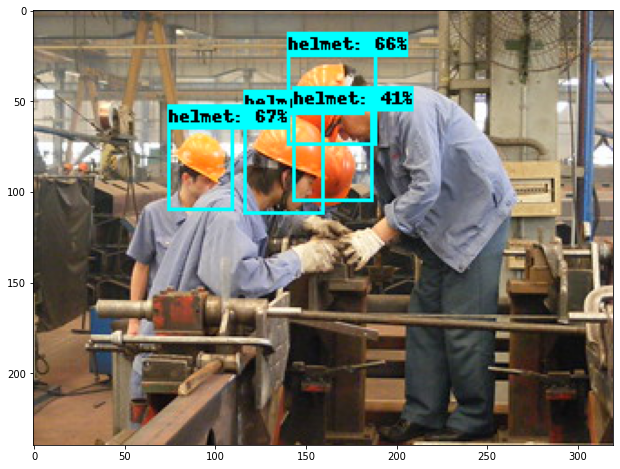

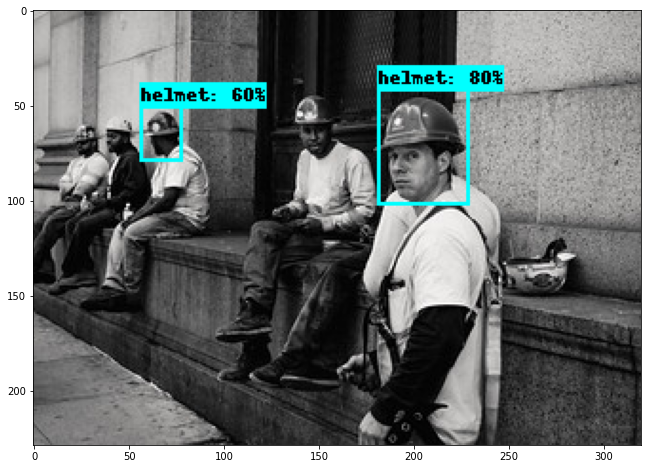

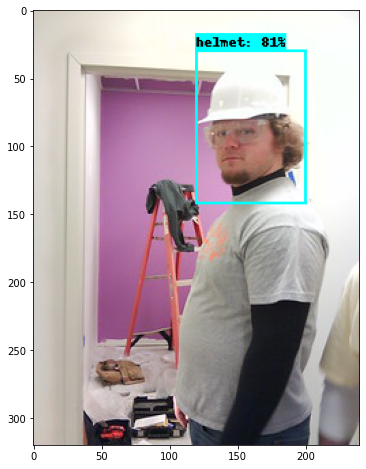

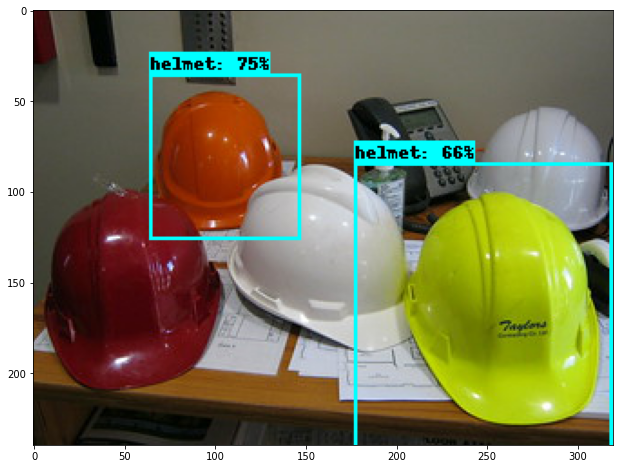

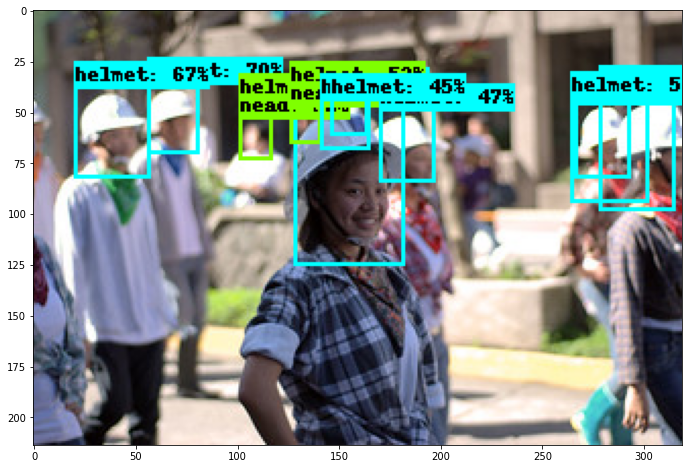

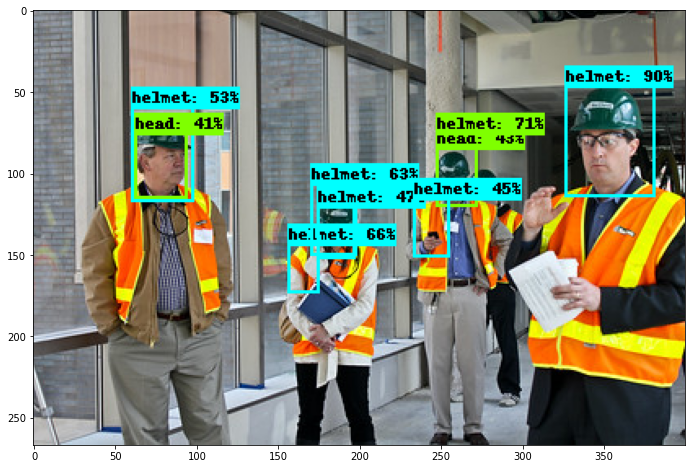

In [30]:
# Do a Quick Evaluation on the inference graph model.
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

# Initialize tf.Graph()
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(OUTPUT_DIR+"/frozen_inference_graph.pb", 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

# Loads labels
label_map = label_map_util.load_labelmap('/content/output_ssdlite_mobiledet_hard_hat/labels.txt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=3, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

test_image_path = [os.path.join('/content/validate_img', 'image_{}.jpg'.format(i)) for i in range(1, 7)]
for image_path in test_image_path:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  img_width, img_height = image.size
  image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
  # Run inference.
  output_dict = run_inference(detection_graph, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.4,
      line_thickness=2)
  plt.figure(figsize=(12, 8))
  plt.imshow(image_np)

# **Evaluate the TFlite model**

Evaluating: /content/validate_img/image_1.jpg
10.0
Helmet 84.375%
Helmet 66.40625%
Helmet 66.40625%


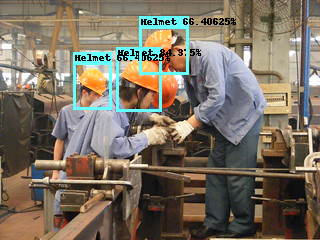

Evaluating: /content/validate_img/image_2.jpg
10.0
Helmet 80.078125%
Helmet 63.28125%


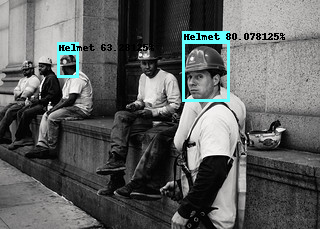

Evaluating: /content/validate_img/image_3.jpg
10.0
Helmet 81.25%


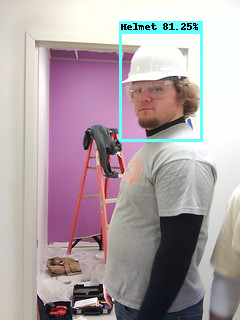

Evaluating: /content/validate_img/image_4.jpg
10.0
Helmet 74.609375%
Helmet 66.40625%


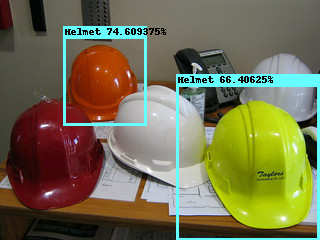

Evaluating: /content/validate_img/image_5.jpg
10.0
Helmet 69.921875%
Helmet 66.40625%
Helmet 66.40625%
Helmet 66.40625%
Helmet 61.328125%
Helmet 53.90625%
Helmet 53.90625%
Helmet 50.0%
Helmet 48.046875%
Helmet 46.09375%


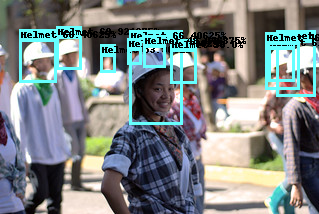

Evaluating: /content/validate_img/image_6.jpg
10.0
Helmet 89.453125%
Helmet 71.484375%
Helmet 66.40625%
Helmet 64.84375%
Helmet 63.28125%
Helmet 46.09375%


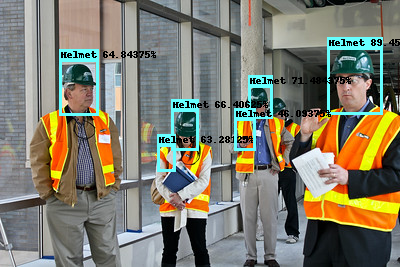

In [32]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = tf.lite.Interpreter(OUTPUT_DIR + '/ssdlite_mobiledet_hard_hat.tflite')
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()

  boxes= interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  print(num_detections)
  return boxes, classes, scores

test_image_paths = [os.path.join('/content/validate_img', 'image_{}.jpg'.format(i)) for i in range(1, 7)]
for image_path in test_image_paths:
  print('Evaluating:', image_path)
  image = Image.open(image_path)
  image_width, image_height = image.size
  draw = ImageDraw.Draw(image)
  resized_image = image.resize((width, height))
  np_image = np.array(resized_image.getdata()).reshape((height, width, 3)).astype(np.uint8)
  input_tensor = np.expand_dims(np_image, axis=0)
  # Run inference
  boxes, classes, scores = run_inference(interpreter, input_tensor)
  # Draw results on image
  colors = {0:(25, 255, 102), 1:(102, 255, 255), 2:(255,255,100)}
  labels = read_label_file(OUTPUT_DIR + '/labels_2.txt')
  for i in range(len(boxes)):
    if scores[i] > 0.4:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=3, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      print(text)
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
  display(image)